In [2]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.trend_filter_R as tfilter
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd

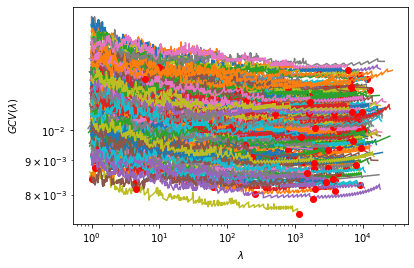

In [12]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/VanderPol_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)

noise_lvls = [0.1]
n_noise_lvls = len(noise_lvls)

mean_X_error = np.zeros((n_states, n_noise_lvls))
mean_dX_error = np.zeros((n_states, n_noise_lvls))

var_X_error = np.zeros((n_states, n_noise_lvls))
var_dX_error = np.zeros((n_states, n_noise_lvls))  

for noise in range(n_noise_lvls):

    # 2) LOAD OBSERVATION SAMPLES
    Y_samples = []
    noise_lvl = str(noise_lvls[noise])

    for state in range(n_states):

        filepath = 'data_files/VanderPol_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
        y = np.genfromtxt(filepath, delimiter=',')

        Y_samples.append(y)

    n_samples = Y_samples[0].shape[0]

    ################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
    trim = int(np.floor(5 / 100 * t_samples))
    error_X = np.zeros((n_samples,n_states))
    error_dX = np.zeros((n_samples,n_states))
    tt_samples = t_samples - 2 * trim
    Yhat_tf = np.zeros((n_samples, tt_samples))
    DYhat_tf = np.zeros((n_samples, tt_samples))

    for state in range(n_states):

        for sample in range(n_samples):
        #CVX code
            y = Y_samples[state][sample,:]

            #Find corner point
            tf = tfilter.gcv(y, t, order = 3, min_lambda = 1)
            y_tf = tf[0]
            y_tf_ss = interpolate.splrep(t, y_tf, k=3, s=0)
            dy_tf = interpolate.splev(t, y_tf_ss, der=1)
            
            #Remove ends
            Yhat_tf[sample,:] = y_tf[trim:-trim]
            DYhat_tf[sample,:] = dy_tf[trim:-trim]
            #Compute errors
            error_X[sample,state] = norm(Yhat_tf[sample,:] - X[state,trim:-trim]) / norm(X[state,trim:-trim])
            error_dX[sample,state] = norm(DYhat_tf[sample,:] - DX[state,trim:-trim]) / norm(DX[state,trim:-trim])
            
        filename_y = 'data_files/trendfilter/VanderPol_trendfilter_gcv_' + noise_lvl + '_Y' + str(state+1) + '.csv'
        filename_dy = 'data_files/trendfilter/VanderPol_trendfilter_gcv_' + noise_lvl + '_dY' + str(state+1) + '.csv'
        with open(filename_y, 'w') as csvfile:   
            # creating a csv writer object   
            csvwriter = csv.writer(csvfile)   
            # writing the data rows   
            csvwriter.writerows(Yhat_tf)
        with open(filename_dy, 'w') as csvfile:   
            # creating a csv writer object   
            csvwriter = csv.writer(csvfile)   
            # writing the data rows   
            csvwriter.writerows(DYhat_tf)

        mean_X_error[state, noise] = error_X[:,state].mean()
        mean_dX_error[state, noise] = error_dX[:,state].mean()
        var_X_error[state, noise] = error_X[:,state].var()
        var_dX_error[state, noise] = error_dX[:,state].var()
        
      

In [13]:

temp = [['$\sigma$ = ' + str(x)] * n_states for x in noise_lvls]
noise_indx = np.array([item for sublist in temp for item in sublist])

state_indx = np.array(['state x' + str(x+1) for x in range(n_states)] * n_noise_lvls)

arrays = [noise_indx, state_indx]
data = np.vstack((mean_X_error.T.flatten(), var_X_error.T.flatten(), mean_dX_error.T.flatten(), var_dX_error.T.flatten())).T

col_names = ['mean error x', 'var. error x', 'mean error dx', 'var. error dx']
df = pd.DataFrame(data, index=arrays, columns=col_names)
df

mean error x  var. error x  mean error dx  \
$\sigma$ = 0.1 state x1      0.020281      0.000096       0.334252   
               state x2      0.054028      0.000648       0.584126   

                         var. error dx  
$\sigma$ = 0.1 state x1       0.227555  
               state x2       0.654504

In [ ]:
#cHEAT SHEET

#lambda_min = 1e-8, lambda_max = 1000